In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, roc_curve, auc
from tensorflow.keras.preprocessing.image import load_img
# Mount Google Drive
drive.mount('/content/drive')

# Dataset Directories
train_dir = "/content/drive/MyDrive/dataset/DataFix/train"
test_dir = "/content/drive/MyDrive/dataset/DataFix/test"
tumor_classes = np.array(['glioma', 'meningioma', 'pituitary'])

# Display dataset structure
print(f"Training data directory: {train_dir}")
print(f"Testing data directory: {test_dir}")
print(f"Tumor classes: {tumor_classes}")

for tumor_class in tumor_classes:
    train_class_dir = os.path.join(train_dir, tumor_class)
    test_class_dir = os.path.join(test_dir, tumor_class)

    if os.path.exists(train_class_dir) and os.path.exists(test_class_dir):
        train_count = len(os.listdir(train_class_dir))
        test_count = len(os.listdir(test_class_dir))
        print(f"Class '{tumor_class}': {train_count} training images, {test_count} testing images")
    else:
        print(f"Warning: Directory for class '{tumor_class}' not found!")

print("Data loading complete!")

Mounted at /content/drive
Training data directory: /content/drive/MyDrive/dataset/DataFix/train
Testing data directory: /content/drive/MyDrive/dataset/DataFix/test
Tumor classes: ['glioma' 'meningioma' 'pituitary']
Class 'glioma': 1140 training images, 286 testing images
Class 'meningioma': 566 training images, 142 testing images
Class 'pituitary': 744 training images, 186 testing images
Data loading complete!


Found 1961 images belonging to 3 classes.
Found 489 images belonging to 3 classes.
Found 614 images belonging to 3 classes.


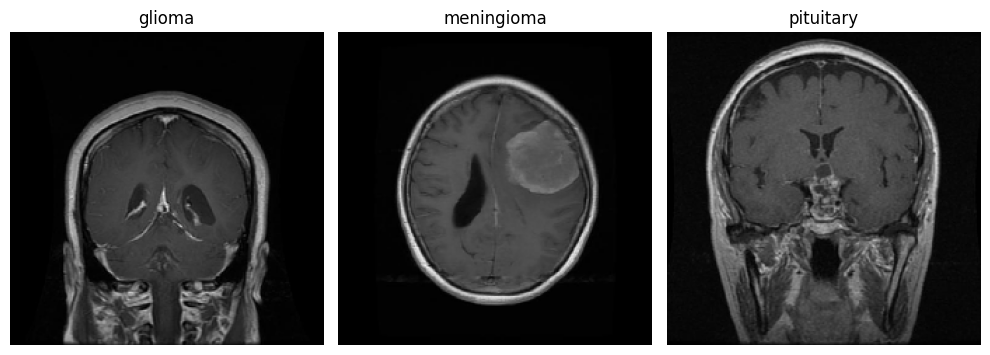

In [ ]:
# Preprocessing dan augmentasi gambar
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Generator untuk training dan validasi
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Generator untuk data pengujian
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
# Display sample images from training data
plt.figure(figsize=(10, 5))
for i, tumor_class in enumerate(tumor_classes):
    class_path = os.path.join(train_dir, tumor_class)
    if os.path.exists(class_path) and os.listdir(class_path):
        random_image = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, random_image)
        original_img = load_img(image_path, target_size=(224, 224))

        plt.subplot(1, len(tumor_classes), i + 1)
        plt.imshow(original_img)
        plt.axis('off')
        plt.title(tumor_class)
plt.tight_layout()
plt.show()

In [ ]:
# Fungsi membuat model CNN VGG16
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Membekukan semua layer VGG16
    for layer in base_model.layers:
        layer.trainable = False

    # Tambahkan lapisan klasifikasi di atas VGG16
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Gabungkan menjadi model akhir
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Membuat dan kompilasi model
model = create_vgg16_model(input_shape=(224, 224, 3), num_classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2083s 33s/step - accuracy: 0.3927 - loss: 1.1409 - val_accuracy: 0.4744 - val_loss: 0.9275 - learning_rate: 1.0000e-04
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 653ms/step - accuracy: 0.4741 - loss: 1.0332 - val_accuracy: 0.6278 - val_loss: 0.8387 - learning_rate: 1.0000e-04
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 652ms/step - accuracy: 0.5489 - loss: 0.9538 - val_accuracy: 0.6074 - val_loss: 0.8003 - learning_rate: 1.0000e-04
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 656ms/step - accuracy: 0.6052 - loss: 0.8738 - val_accuracy: 0.6646 - val_loss: 0.7210 - learning_rate: 1.0000e-04
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 655ms/step - accuracy: 0.6478 - loss: 0.8259 - val_accuracy: 0.6605 - val_loss: 0.7138 - learning_rate: 1.0000e-04
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 656ms/step - accuracy: 0.6837 - loss: 0.7804 - val_accuracy: 0.6524 - val_loss: 0.6876 - learning_rate: 1.0000e-04
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 702ms/step - acc

In [ ]:
# Evaluasi model
test_loss, test_acc = model.evaluate(test_generator)
print("Akurasi pada data uji:", test_acc)

# Prediksi pada data uji
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Evaluasi klasifikasi
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

# Simpan model
model.save('vgg16_model_mushroom.h5')

614/614 ━━━━━━━━━━━━━━━━━━━━ 513s 834ms/step - accuracy: 0.8499 - loss: 0.4283
Akurasi pada data uji: 0.7801302671432495
614/614 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step


Classification Report
              precision    recall  f1-score   support

      glioma       0.78      0.90      0.83       286
  meningioma       0.75      0.32      0.45       142
   pituitary       0.79      0.95      0.86       186

    accuracy                           0.78       614
   macro avg       0.77      0.72      0.72       614
weighted avg       0.78      0.78      0.75       614

Confusion Matrix
[[257  15  14]
 [ 64  46  32]
 [ 10   0 176]]
